In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/steel-defect-detection/defect_and_no_defect.csv
/kaggle/input/steel-defect-detection/train.csv
/kaggle/input/steel-defect-detection/test.csv
/kaggle/input/steel-defect-detection/train_images/f1bd3a48a.jpg
/kaggle/input/steel-defect-detection/train_images/55042415c.jpg
/kaggle/input/steel-defect-detection/train_images/1dba99dc5.jpg
/kaggle/input/steel-defect-detection/train_images/636700b91.jpg
/kaggle/input/steel-defect-detection/train_images/e865201fb.jpg
/kaggle/input/steel-defect-detection/train_images/cbb659739.jpg
/kaggle/input/steel-defect-detection/train_images/1849f8952.jpg
/kaggle/input/steel-defect-detection/train_images/e7a980a8f.jpg
/kaggle/input/steel-defect-detection/train_images/50fb57a6c.jpg
/kaggle/input/steel-defect-detection/train_images/2f8a16cc3.jpg
/kaggle/input/steel-defect-detection/train_images/94a3786cb.jpg
/kaggle/input/steel-defect-detection/train_images/59b5007ed.jpg
/kaggle/input/steel-defect-detection/train_images/ceb4d3861.jpg
/kaggle/input

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import zipfile
import cv2
from skimage import io
import tensorflow as tf
from tensorflow.python.keras import Sequential
from tensorflow.keras import layers, optimizers
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, LearningRateScheduler
from IPython.display import display
from tensorflow.keras import backend as K
from sklearn.preprocessing import StandardScaler, normalize
import os
%matplotlib inline

In [4]:
# data containing defect images with segmentation mask 
defect_class_mask_df = pd.read_csv('/kaggle/input/steel-defect-detection/train.csv')
# data containing defective and non defective images
all_images_df = pd.read_csv('/kaggle/input/steel-defect-detection/defect_and_no_defect.csv')

In [5]:
defect_class_mask_df.head()

,ImageId,ClassId,EncodedPixels
0,d2291de5c.jpg,1,147963 3 148213 9 148461 18 148711 24 148965 2...
1,78416c3d0.jpg,3,54365 3 54621 7 54877 10 55133 12 55388 14 556...
2,2283f2183.jpg,3,201217 43 201473 128 201729 213 201985 5086 20...
3,f0dc068a8.jpg,3,159207 26 159412 77 159617 128 159822 179 1600...
4,00d639396.jpg,3,229356 17 229595 34 229850 36 230105 37 230360...


In [6]:
all_images_df.head()

,ImageID,label
0,0002cc93b.jpg,1
1,0007a71bf.jpg,1
2,000a4bcdd.jpg,1
3,000f6bf48.jpg,1
4,0014fce06.jpg,1


# Exploratory Data Analysis

In [7]:
defect_class_mask_df['mask'] = defect_class_mask_df['ClassId'].map(lambda x: 1)

### an exact same image id might belong to more than one class

In [8]:
defect_class_mask_df.head()

,ImageId,ClassId,EncodedPixels,mask
0,d2291de5c.jpg,1,147963 3 148213 9 148461 18 148711 24 148965 2...,1
1,78416c3d0.jpg,3,54365 3 54621 7 54877 10 55133 12 55388 14 556...,1
2,2283f2183.jpg,3,201217 43 201473 128 201729 213 201985 5086 20...,1
3,f0dc068a8.jpg,3,159207 26 159412 77 159617 128 159822 179 1600...,1
4,00d639396.jpg,3,229356 17 229595 34 229850 36 230105 37 230360...,1


Text(0.5, 1.0, 'Number of images per class')

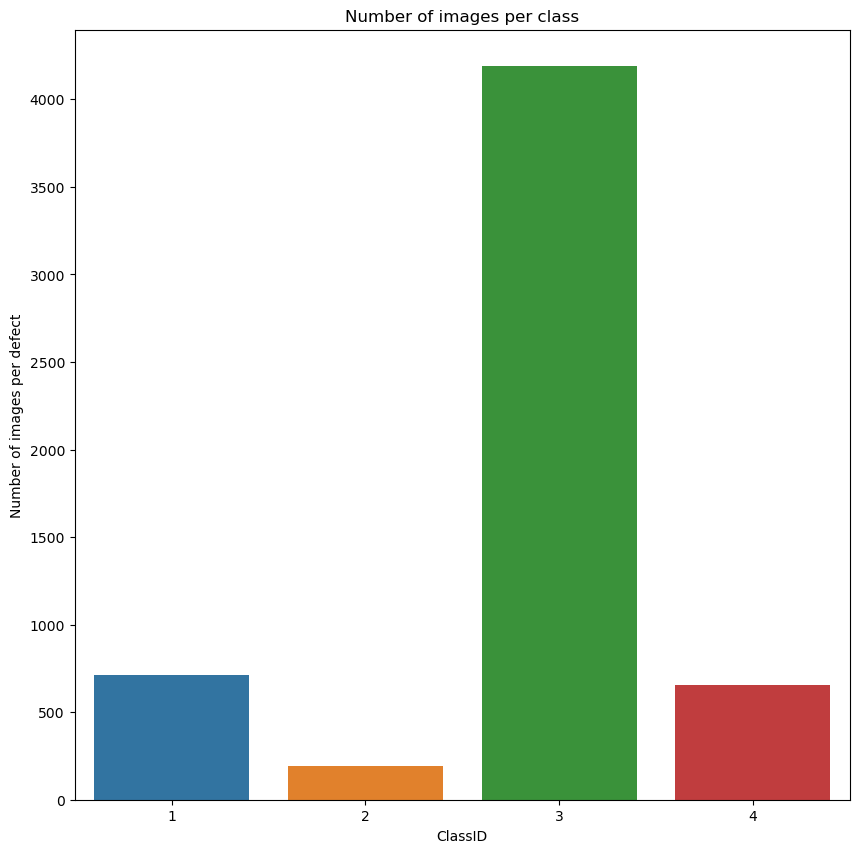

In [9]:
plt.figure(figsize=(10,10))
sns.countplot(x = 'ClassId',data = defect_class_mask_df)
plt.ylabel('Number of images per defect')
plt.xlabel('ClassID')
plt.title('Number of images per class')

In [10]:
# Some images are classified with more than one defect, let's explore this futher
# we have one image with 3 types of defects 
# we have 272 images with 2 types of defects
# we have 5201 images with 1 type of defect
defect_type = defect_class_mask_df.groupby(['ImageId'])['mask'].sum()

In [11]:
defect_type

ImageId
0002cc93b.jpg    1
0007a71bf.jpg    1
000a4bcdd.jpg    1
000f6bf48.jpg    1
0014fce06.jpg    1
                ..
ffcf72ecf.jpg    1
fff02e9c5.jpg    1
fffe98443.jpg    1
ffff4eaa8.jpg    1
ffffd67df.jpg    1
Name: mask, Length: 5474, dtype: int64

In [12]:
defect_type.value_counts()

1    5201
2     272
3       1
Name: mask, dtype: int64

Text(0.5, 1.0, 'Number of defects in image')

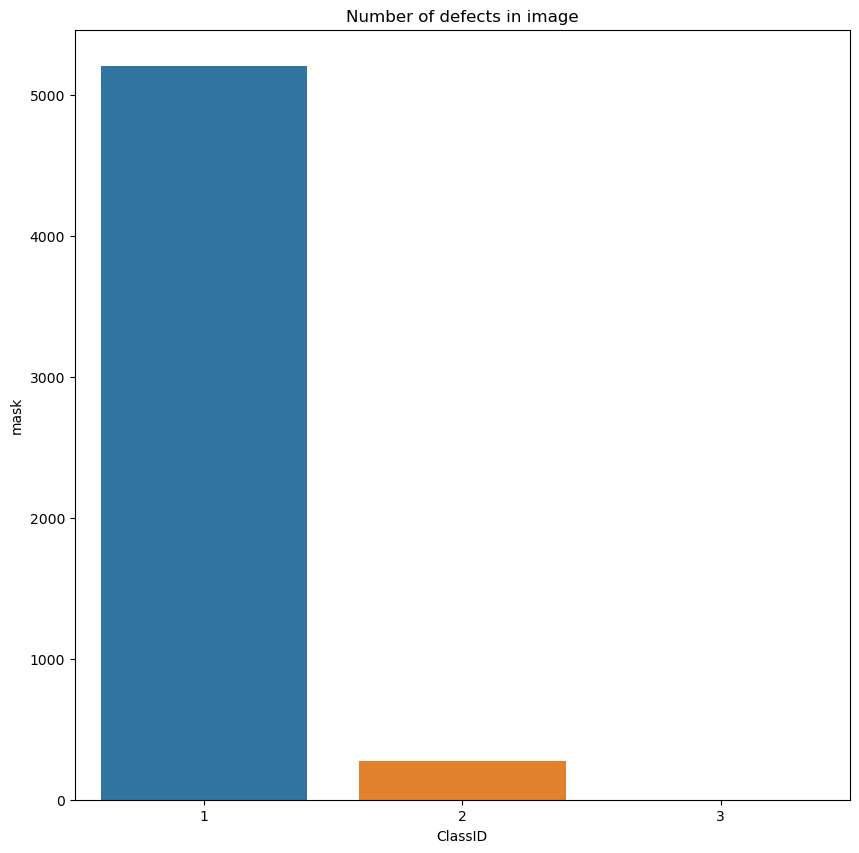

In [13]:
plt.figure(figsize=(10,10))
sns.barplot(x = defect_type.value_counts().index, y = defect_type.value_counts() )
plt.xlabel('ClassID')
plt.title('Number of defects in image')

In [14]:
defect_class_mask_df.shape

(5748, 4)

In [15]:
all_images_df.shape

(12997, 2)

In [16]:
all_images_df.label.value_counts()
# no of defective and non-defective images

1    7095
0    5902
Name: label, dtype: int64

Text(0.5, 1.0, 'Defect and non-defect images')

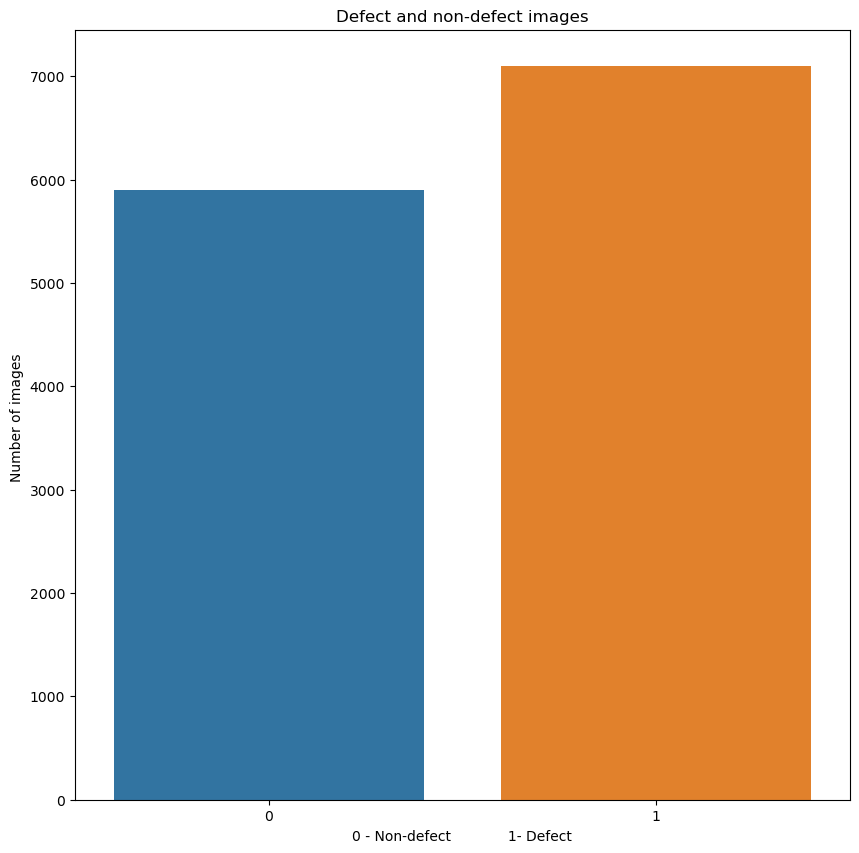

In [17]:
plt.figure(figsize=(10,10))
sns.barplot(x = all_images_df.label.value_counts().index, y = all_images_df.label.value_counts() )
plt.ylabel('Number of images ')
plt.xlabel('0 - Non-defect             1- Defect')
plt.title('Defect and non-defect images')

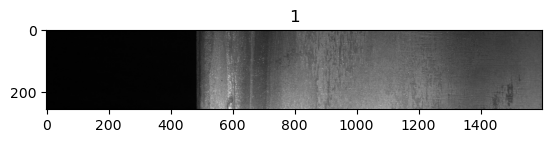

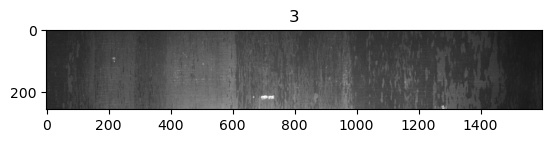

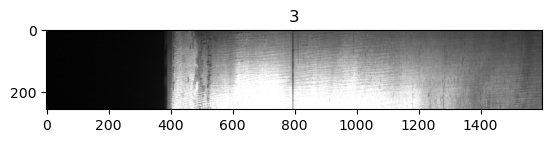

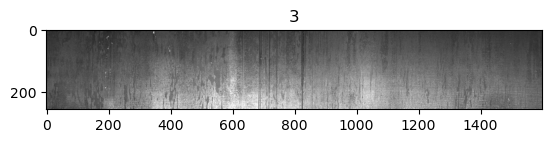

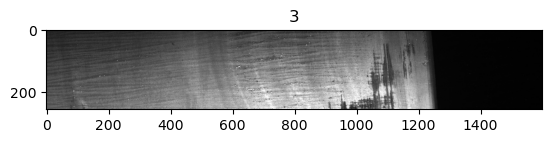

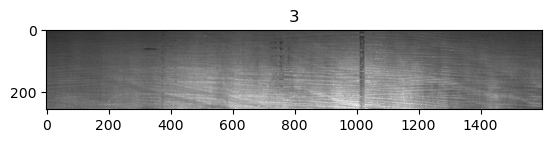

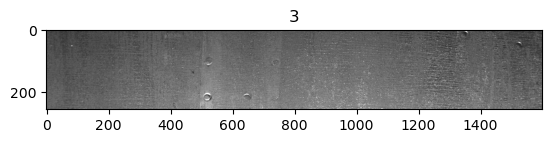

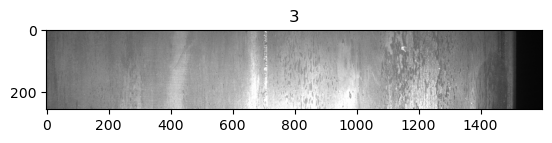

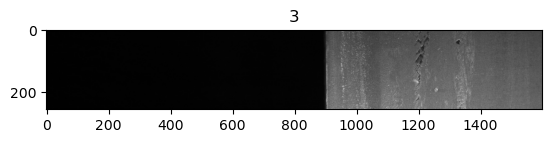

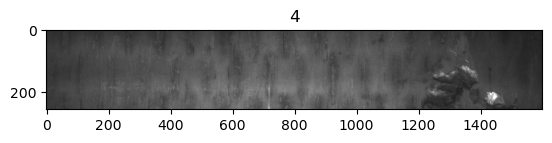

In [18]:
# Visualize images with defects along with their corresponding labels
# Images are 256 x 1600
train_dir = '/kaggle/input/steel-defect-detection/train_images/'

for i in range(10):
    # Specify the path to the images given their image ID
    img = io.imread(os.path.join(train_dir, defect_class_mask_df.ImageId[i]))
    plt.figure()
    plt.title(defect_class_mask_df.ClassId[i])
    plt.imshow(img)

In [19]:
def mask2rle(img):
    '''
    img: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    '''
    pixels= img.T.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)
 
def rle2mask(mask_rle, shape=(1600,256)):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (width,height) of array to return 
    Returns numpy array, 1 - mask, 0 - background

    '''
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape).T

In [24]:
# Let's try to use the rle2mask on a sample image 
image_index = 20 #20 30
mask = rle2mask(defect_class_mask_df.EncodedPixels[image_index], (img.shape[1], img.shape[0]))
mask.shape

(256, 1600)

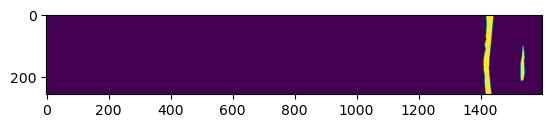

In [25]:
plt.imshow(mask)

(256, 1600, 3)

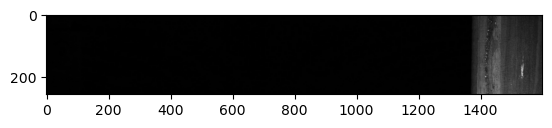

In [23]:
img = io.imread(os.path.join(train_dir, defect_class_mask_df.ImageId[image_index]))
plt.imshow(img)
img.shape

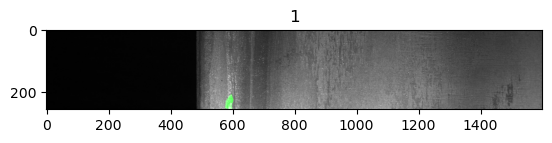

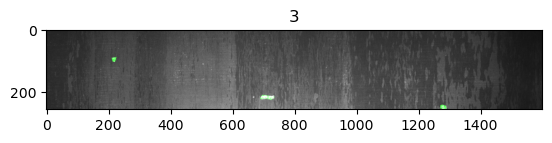

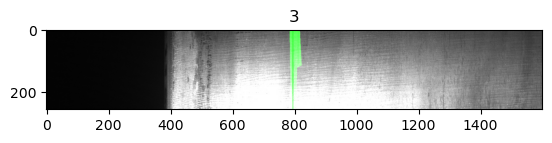

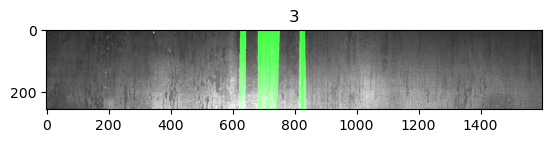

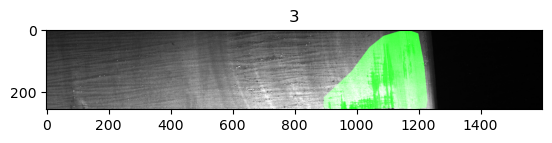

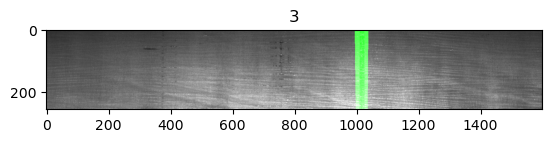

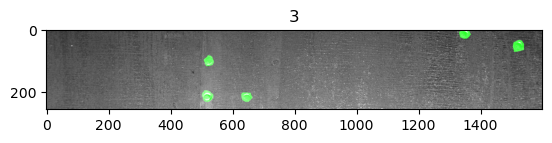

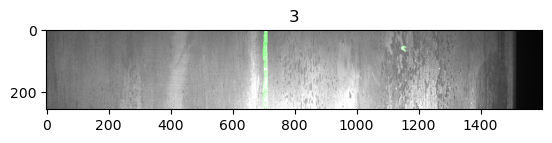

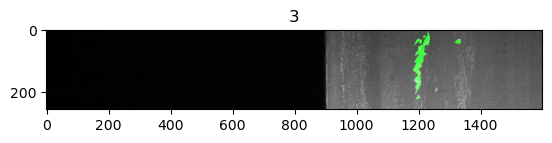

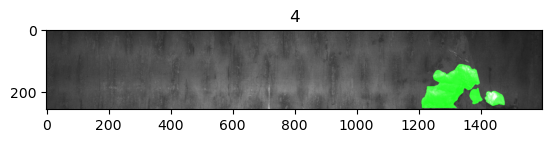

In [27]:
for i in range(10):
    # Read the images using opencv and converting to rgb format
    img = io.imread(os.path.join(train_dir, defect_class_mask_df.ImageId[i]))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    # Get the mask for the image from rle
    mask = rle2mask(defect_class_mask_df.EncodedPixels[i], (img.shape[1], img.shape[0]))
    # Let's color the pixels with values = 1 
    img[mask == 1,1] = 255
    plt.figure()
    plt.imshow(img)
    plt.title(defect_class_mask_df.ClassId[i])


# Model Building

In [28]:
# split the data (defective and non defective) into training and testing 
from sklearn.model_selection import train_test_split
train, test = train_test_split(all_images_df, test_size=0.15)

In [29]:
train.shape

(11047, 2)

In [30]:
train_dir = '/kaggle/input/steel-defect-detection/train_images/'


In [32]:
# create a image generator for the training and validation dataset
# we will divide the data to training, validation and testing
# Training = 9390 
# validation = 1657 
# testing = 1950 

from keras.preprocessing.image import ImageDataGenerator

# Create a data generator which scales the data from 0 to 1 and makes validation split of 0.15
datagen = ImageDataGenerator(rescale=1./255., validation_split = 0.15)

train_generator = datagen.flow_from_dataframe(
dataframe = train,
directory = train_dir,
x_col = "ImageID",
y_col = "label",
subset = "training",
batch_size = 16,
shuffle = True,
class_mode = "other",
target_size = (256, 256))


valid_generator = datagen.flow_from_dataframe(
dataframe = train,
directory = train_dir,
x_col = "ImageID",
y_col = "label",
subset = "validation",
batch_size = 16,
shuffle = True,
class_mode = "other",
target_size = (256, 256))

Found 9390 validated image filenames.
Found 1657 validated image filenames.


In [33]:
# Create a data generator for test images
test_datagen = ImageDataGenerator(rescale=1./255.)

test_generator = test_datagen.flow_from_dataframe(
dataframe = test,
directory = train_dir,
x_col = "ImageID",
y_col = None,
batch_size = 16,
shuffle = False,
class_mode = None,
target_size = (256, 256))


Found 1950 validated image filenames.


In [34]:
basemodel = ResNet50(weights = 'imagenet', include_top = False, input_tensor = Input(shape=(256,256,3)))

94765736/94765736 [==============================] - 0s 0us/step


In [35]:
basemodel.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 262, 262, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 128, 128, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                           

In [36]:
# freeze the model weights

for layer in basemodel.layers:
    layers.trainable = True

In [37]:
headmodel = basemodel.output
headmodel = AveragePooling2D(pool_size = (4,4))(headmodel)
headmodel = Flatten(name= 'flatten')(headmodel)
headmodel = Dense(256, activation = "relu")(headmodel)
headmodel = Dropout(0.3)(headmodel)
headmodel = Dense(1, activation = 'sigmoid')(headmodel)

model = Model(inputs = basemodel.input, outputs = headmodel)

In [38]:
model.compile(loss = 'binary_crossentropy', optimizer='Nadam', metrics= ["accuracy"])

In [39]:
# use early stopping to exit training if validation loss is not decreasing even after certain epochs (patience)
earlystopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)

# save the best model with least validation loss
checkpointer = ModelCheckpoint(filepath="resnet-weights.hdf5", verbose=1, save_best_only=True)

In [40]:
history = model.fit_generator(train_generator, steps_per_epoch= train_generator.n // 16, epochs = 40, validation_data= valid_generator, validation_steps= valid_generator.n // 16, callbacks=[checkpointer, earlystopping])

/tmp/ipykernel_28/2052154647.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_generator, steps_per_epoch= train_generator.n // 16, epochs = 40, validation_data= valid_generator, validation_steps= valid_generator.n // 16, callbacks=[checkpointer, earlystopping])


Epoch 1/40
586/586 [==============================] - ETA: 0s - loss: 0.5787 - accuracy: 0.7211
Epoch 1: val_loss improved from inf to 0.68747, saving model to resnet-weights.hdf5
586/586 [==============================] - 183s 191ms/step - loss: 0.5787 - accuracy: 0.7211 - val_loss: 0.6875 - val_accuracy: 0.5534
Epoch 2/40
586/586 [==============================] - ETA: 0s - loss: 0.4289 - accuracy: 0.8025
Epoch 2: val_loss improved from 0.68747 to 0.62900, saving model to resnet-weights.hdf5
586/586 [==============================] - 101s 173ms/step - loss: 0.4289 - accuracy: 0.8025 - val_loss: 0.6290 - val_accuracy: 0.6887
Epoch 3/40
586/586 [==============================] - ETA: 0s - loss: 0.3843 - accuracy: 0.8287
Epoch 3: val_loss did not improve from 0.62900
586/586 [==============================] - 102s 174ms/step - loss: 0.3843 - accuracy: 0.8287 - val_loss: 0.9493 - val_accuracy: 0.7239
Epoch 4/40
586/586 [==============================] - ETA: 0s - loss: 0.3382 - accuracy:

# Save the model

In [41]:
# save the trained model architecture for future use

model_json = model.to_json()
with open("resnet-classifier-model.json","w") as json_file:
    json_file.write(model_json)

# Load the model

In [42]:
with open('/kaggle/working/resnet-classifier-model.json', 'r') as json_file:
    json_savedModel= json_file.read()
# load the model  
model = tf.keras.models.model_from_json(json_savedModel)
model.load_weights('/kaggle/working/resnet-weights.hdf5')
model.compile(loss = 'binary_crossentropy', optimizer='Nadam', metrics= ["accuracy"])

# Evaluation of the model

In [44]:


from keras.preprocessing.image import ImageDataGenerator

test_predict = model.predict(test_generator, steps = test_generator.n // 16, verbose =1)

121/121 [==============================] - 22s 168ms/step


In [45]:

predict = []

for i in test_predict:
    if i < 0.01: #0.5
        predict.append(0)
    else:
        predict.append(1)

predict = np.asarray(predict)

In [46]:
len(predict)

1936

In [47]:
# since we have used test generator, it limited the images to 1936, due to batch size

original = np.asarray(test.label)[:1936]
len(original)

1936

In [48]:
# Find the accuracy of the model
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(original, predict)
accuracy

0.8827479338842975

<Axes: >

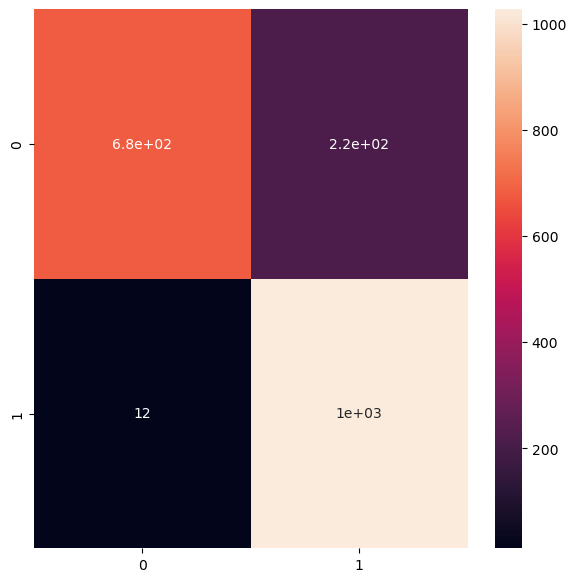

In [49]:
# Plot the confusion matrix
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(original, predict)
plt.figure(figsize = (7,7))
sns.heatmap(cm, annot=True)

In [50]:
# Print the classification report

from sklearn.metrics import classification_report

report = classification_report(original,predict, labels = [0,1])
print(report)

              precision    recall  f1-score   support

           0       0.98      0.76      0.86       897
           1       0.83      0.99      0.90      1039

    accuracy                           0.88      1936
   macro avg       0.90      0.87      0.88      1936
weighted avg       0.90      0.88      0.88      1936

